In [2]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(0) 

In [4]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


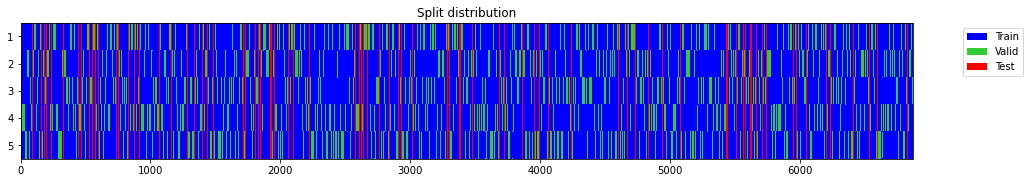

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [31]:

cv_splits = get_splits(y.to_numpy(), n_splits = 5, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.310255,0.245854,0.916712,0.674658,0.870656,0.356457,0.992859,0.504676,00:05
1,0.229135,0.190027,0.932597,0.766389,0.832759,0.547861,0.984918,0.659346,00:05
2,0.189132,0.173374,0.939239,0.790157,0.851807,0.594175,0.986138,0.698938,00:05
3,0.168184,0.170672,0.940406,0.807336,0.828790,0.632418,0.982255,0.717045,00:05
4,0.156501,0.181071,0.935380,0.796574,0.798533,0.614147,0.979001,0.693694,00:05
5,0.150427,0.161748,0.943008,0.813990,0.842164,0.644400,0.983581,0.729725,00:05
6,0.145434,0.165673,0.940944,0.812221,0.824327,0.643000,0.981443,0.722025,00:05
7,0.140478,0.147174,0.946150,0.833920,0.833477,0.686396,0.981444,0.752513,00:05
8,0.133961,0.162116,0.942111,0.820953,0.818896,0.661680,0.980226,0.731608,00:05
9,0.134041,0.143963,0.950099,0.830965,0.879916,0.674369,0.987561,0.762796,00:05


Better model found at epoch 0 with F1_multi value: 0.504676103591919.


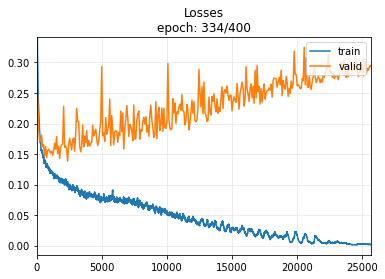

Better model found at epoch 1 with F1_multi value: 0.6593455672264099.
Better model found at epoch 2 with F1_multi value: 0.6989384293556213.
Better model found at epoch 3 with F1_multi value: 0.7170448303222656.
Better model found at epoch 5 with F1_multi value: 0.729724645614624.
Better model found at epoch 7 with F1_multi value: 0.7525127530097961.
Better model found at epoch 9 with F1_multi value: 0.7627955675125122.
Better model found at epoch 14 with F1_multi value: 0.7635321617126465.
Better model found at epoch 19 with F1_multi value: 0.7763453722000122.
Better model found at epoch 22 with F1_multi value: 0.7859756350517273.
Better model found at epoch 80 with F1_multi value: 0.7868762016296387.
Better model found at epoch 133 with F1_multi value: 0.786934494972229.
Better model found at epoch 157 with F1_multi value: 0.7886195778846741.
Better model found at epoch 158 with F1_multi value: 0.7940430641174316.
Better model found at epoch 170 with F1_multi value: 0.79448026418685

In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
              tfs.Normalize(),
#               tfs.RandomShift(0.1),
              tfs.MulNoise(5),
#               tfs.CutOutWhenTraining(),
              tfs.Scale(scale_factor=0.3)
             ]
for cv_num in range(5):
    cv_num = cv_num
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
    # model = MiniRocketPlus(dls.vars, dls.c,2500)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=12,)

    learn = Learner(dls, model, metrics=metrics,  opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=1e-5),
                    cbs=[ShowGraph(),SaveModelCallback(monitor="F1_multi",fname="inception_%s"%cv_num)],
                    model_dir="models/10CV/")
    learn.fit_one_cycle(400, lr_max=0.01)
    learn.recorder.plot_metrics()

### check f1s

In [93]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
              tfs.Normalize(),
#               tfs.RandomShift(0.1),
              tfs.MulNoise(5),
#               tfs.CutOutWhenTraining(),
              tfs.Scale(scale_factor=0.2)
             ]
reports = []
for cv_num in range(5):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[2])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph(),SaveModelCallback(monitor="F1_multi",fname="inception_%s"%cv_num)],
                    model_dir="models/10CV/")
    learn.load("inception_%s"%cv_num)
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)

In [92]:
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
pd.DataFrame(rc).median()

1st degree av block             0.829630
atrial fibrillation             0.928870
left bundle branch block        0.883721
premature atrial contraction    0.448980
right bundle branch block       0.942708
sinus rhythm                    0.700000
st depression                   0.758242
st elevation                    0.451613
ventricular ectopics            0.688742
micro avg                       0.807640
macro avg                       0.744633
weighted avg                    0.799595
samples avg                     0.775109
dtype: float64

In [90]:
pd.DataFrame(rc).median()

1st degree av block             0.829630
atrial fibrillation             0.928870
left bundle branch block        0.883721
premature atrial contraction    0.448980
right bundle branch block       0.942708
sinus rhythm                    0.700000
st depression                   0.758242
st elevation                    0.451613
ventricular ectopics            0.688742
micro avg                       0.807640
macro avg                       0.744633
weighted avg                    0.799595
samples avg                     0.775109
dtype: float64

,1st degree av block,atrial fibrillation,left bundle branch block,premature atrial contraction,right bundle branch block,sinus rhythm,st depression,st elevation,ventricular ectopics,micro avg,macro avg,weighted avg,samples avg
0,0.829630,0.876033,0.777778,0.367816,0.918782,0.694611,0.748603,0.451613,0.680272,0.782793,0.705015,0.766822,0.748666
1,0.820896,0.928870,0.883721,0.547170,0.942708,0.700000,0.790960,0.358974,0.728395,0.811475,0.744633,0.805848,0.777778
2,0.808824,0.929461,0.850000,0.574257,0.943590,0.710383,0.758242,0.411765,0.728395,0.812798,0.746102,0.805496,0.780689
3,0.840580,0.926407,0.883721,0.448980,0.951899,0.700000,0.755814,0.487805,0.666667,0.801906,0.740208,0.794573,0.766133
4,0.830769,0.937759,0.926829,0.442105,0.932292,0.736318,0.762431,0.523810,0.688742,0.807640,0.753451,0.799595,0.775109
